In [1]:
from os.path import join
import json

from nltk.stem.snowball import SnowballStemmer
import numpy as np

from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as smet
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.ensemble import GradientBoostingClassifier


import re
import string
import random

import matplotlib.pyplot as plt

savePlots = False

In [2]:
washington_list1 = ["seattle","washington","wa","kirkland"]

washington_list2 = ["dc","d.c.","d.c."]

massachusetts_list1 = ["ma", "massachusetts","boston","worcester","salem","plymouth",
                       "springfield","arlington","scituate","northampton"]

massachusetts_list2 = ["ohio"]

In [3]:
def in_washington(location):

    inWashington = False
    location = location.split()

    for s in washington_list1:
        if s in location:
            inWashington = True
            break

    for s in washington_list2:
        if s in location:
            inWashington = False
            break

    return inWashington


def in_massachusetts(location):

    location = location.split()
    inMassachusetts = False

    for s in massachusetts_list1:
        if s in location:
            inMassachusetts = True
            break

    for s in massachusetts_list2:
        if s in location:
            inMassachusetts = False
            break

    return inMassachusetts

In [4]:
class StemTokenizer(object):
    def __init__(self):
        self.snowball_stemmer = SnowballStemmer("english")

    def __call__(self, doc):
        doc = re.sub('[,.-:/()?{}*$#&]', ' ', doc)
        doc = ''.join(ch for ch in doc if ch not in string.punctuation)
        doc = ''.join(ch for ch in doc if ord(ch) < 128)
        doc = doc.lower()
        words = doc.split()
        words = [word for word in words if word not in text.ENGLISH_STOP_WORDS]

        return [
            self.snowball_stemmer.stem(word) for word in words
        ]

def get_vectorizer():
    return CountVectorizer(
        tokenizer=StemTokenizer(),
        lowercase=True,
        min_df = 2,
        max_df = 0.99
    )

def get_tfid_transformer():
    return TfidfTransformer(
        norm='l2',
        sublinear_tf=True
    )

def get_truncadtedSVD():
    return TruncatedSVD(n_components=100)
 

In [5]:
def print_statistics(actual, predicted):
    print "Accuracy is ", smet.accuracy_score(actual, predicted) * 100
    print "Precision is ", smet.precision_score(actual, predicted, average='macro') * 100
    print "Recall is ", smet.recall_score(actual, predicted, average='macro') * 100
    print "Confusion Matrix is ", smet.confusion_matrix(actual, predicted)

def plot_roc(actual, predicted, classifier_name):
    x, y, _ = roc_curve(actual, predicted)
    roc_auc = auc(x, y)
    plt.plot(x, y, label = 'AUC = %0.2f' %roc_auc)
    plt.plot([0, 1], [0, 1])

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.2])

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)', rotation=90)
    plt.title('ROC Curves for ' + classifier_name + ' Classifier')
    plt.legend(loc="best")
    
    if savePlots:
        plt.savefig('plots/' + classifier_name + '.png', format='png')
    plt.show()
    plt.clf()


In [6]:
def classify(X, Y, classifier, cname):
    b =  int(round(0.9 * X.shape[0]))
    X_train = X[:b, :]
    Y_train = Y[:b]

    X_test = X[b:, :]
    Y_test = Y[b:]

    classifier.fit(X_train, Y_train)
    predicted = classifier.predict(X_test)
    predicted_probs = classifier.predict_proba(X_test)

    print_statistics(Y_test, predicted)
    plot_roc(Y_test, predicted_probs[:, 1], cname)


########################################
Loading superbowl tweets
########################################


----------------------------------------
Computing the LSI representation of the dataset
----------------------------------------




----------------------------------------
Statistics of SVM classifier:
Accuracy is  79.65517241379311
Precision is  83.09142486529464
Recall is  78.29578613223657
Confusion Matrix is  [[1143  726]
 [ 100 2091]]


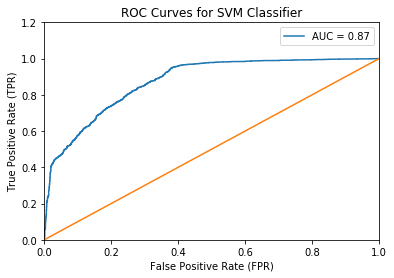

----------------------------------------


----------------------------------------
Statistics of AdaBoost Classifier are
Accuracy is  78.42364532019704
Precision is  79.52230097773321
Recall is  77.52039754050021
Confusion Matrix is  [[1236  633]
 [ 243 1948]]


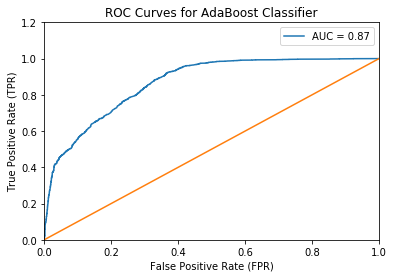

----------------------------------------


----------------------------------------
Statistics of Random Forest Classifier are
Accuracy is  67.36453201970444
Precision is  73.08832854638368
Recall is  65.11546213057503
Confusion Matrix is  [[ 687 1182]
 [ 143 2048]]


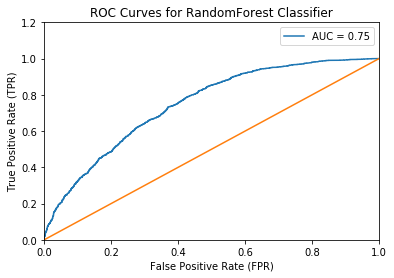

----------------------------------------


----------------------------------------
Statistics of Neural Network Classifier are
Accuracy is  79.60591133004927
Precision is  82.69364387857321
Recall is  78.30125624575852
Confusion Matrix is  [[1156  713]
 [ 115 2076]]


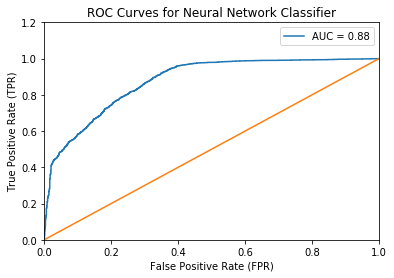

----------------------------------------


----------------------------------------
Statistics of KNN Classifier are
Accuracy is  74.16256157635468
Precision is  74.18080608681058
Recall is  73.64319817024703
Confusion Matrix is  [[1254  615]
 [ 434 1757]]


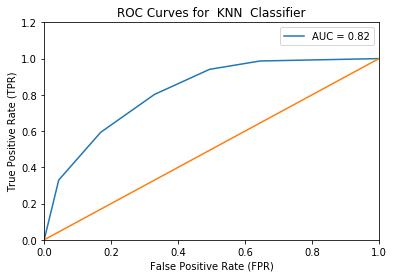

----------------------------------------


----------------------------------------
Statistics of Gradient Boosting Classifier are
Accuracy is  79.50738916256158
Precision is  82.02944597880891
Recall is  78.30040154052071
Confusion Matrix is  [[1179  690]
 [ 142 2049]]


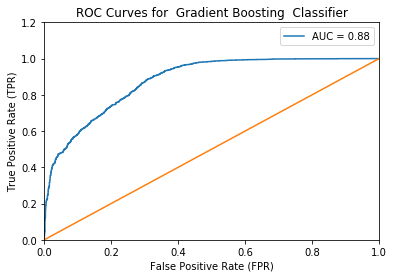

----------------------------------------


In [7]:
print "#"*40
print "Loading superbowl tweets"
print "#"*40
print "\n"
lcount = 1348767

with open(join('tweet_data', 'tweets_#superbowl.txt'), 'r') as f:
    X = []
    Y = []
    for i, line in enumerate(f):
        tweet_data = json.loads(line)
        location = tweet_data.get("tweet").get("user").get("location").lower()

        if in_washington(location):
            X.append(tweet_data.get("title"))
            Y.append(0)
        elif in_massachusetts(location):
            X.append(tweet_data.get("title"))
            Y.append(1)

    pipeline = Pipeline(
        [
            ('vectorize', get_vectorizer()),
            ('tf-idf', get_tfid_transformer()),
            ('svd', get_truncadtedSVD())
        ]
    )
    print "-"*40
    print "Computing the LSI representation of the dataset"
    print "-"*40
    print "\n"
    X = pipeline.fit_transform(X)
    Y = np.array(Y)

    # Randomly shuffle data
    indexes = range(X.shape[0])
    random.shuffle(indexes)
    indexes = indexes
    X_ = X[indexes, :]
    Y_ = Y[indexes]
    
    print "\n"
    print "-"*40
    print "Statistics of SVM classifier:"
    classify(X_, Y_, svm.SVC(kernel='linear', probability=True), "SVM")
    print "-"*40
    
    print "\n"
    print "-"*40
    print "Statistics of AdaBoost Classifier are"
    classify(X_, Y_, AdaBoostClassifier(), "AdaBoost")
    print "-"*40
    
    print "\n"
    print "-"*40
    print "Statistics of Random Forest Classifier are"
    classify(X_, Y_, RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), "RandomForest")
    print "-"*40
    
    print "\n"
    print "-"*40
    print "Statistics of Neural Network Classifier are"
    classify(X_, Y_, MLPClassifier(alpha=1), "Neural Network")
    print "-"*40
    
    print "\n"
    print "-"*40
    print "Statistics of KNN Classifier are"
    classify(X_, Y_, KNeighborsClassifier(n_neighbors=5), " KNN ")
    print "-"*40
    
    print "\n"
    print "-"*40
    print "Statistics of Gradient Boosting Classifier are"
    classify(X_, Y_, GradientBoostingClassifier(), " Gradient Boosting ")
    print "-"*40